In [1]:
# Notebook to backtest the curve strategy with simple assumptions:
# - Rebalancing every T period
# - Assume we can perfectly guess which pool will have the best APY in the next period
# - No rebalancing fees when moving funds from one pool to another e.g. gas fees, slippage or bridging fees
# - No impermanent loss. Assume that the price of the underlying assets is constant
# - No compounding of interest.

import json
import os
import time
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import json
import asyncio
from web3 import Web3, HTTPProvider, AsyncHTTPProvider
from web3.eth import AsyncEth
from Dispatcher import Dispatcher
import nest_asyncio
nest_asyncio.apply()


In [2]:
# Pool pre-filtering: duplicate, volume, apy
chains = ['ethereum', 'polygon', 'arbitrum']
chain_pool_dict = {c:{} for c in chains}
with open('curve_requests/banned_pools.json') as f:
    banned_pools = json.load(f)

for chain in chains:
    with open('curve_requests/' + chain + '/' + chain + '.json') as f:
        chain_main_data = json.load(f)

    pool_list = chain_main_data['data']["poolList"]
    ignored = {"dup": 0, "vol": 0, "apy": 0, "ban": 0}
    for pool in pool_list:
        if pool['address'] in chain_pool_dict[chain]:
            print(f"Duplicate pool: {pool['address']}")
            ignored['dup'] += 1
            continue
        
        if float(pool['volumeUSD']) < 1e3:
            # print(f"Volume < 10k: {pool['address']}")
            ignored['vol'] += 1
            continue

        if float(pool['latestWeeklyApy']) < 0.5:
            # print(f"APY < 1%: {pool['address']}")
            ignored['apy'] += 1
            continue

        if pool['address'] in banned_pools:
            # print(f"Banned pool: {pool['address']}")
            ignored['ban'] += 1
            continue
        
        chain_pool_dict[chain][pool['address']] = pool
        # print(f"{chain} {pool['address']} {pool['latestWeeklyApy']} {pool['volumeUSD']}")

    print(f"Pools ({chain}): {len(chain_pool_dict[chain])}, ignored: {ignored}")

Pools (ethereum): 39, ignored: {'dup': 0, 'vol': 669, 'apy': 80, 'ban': 7}
Pools (polygon): 3, ignored: {'dup': 0, 'vol': 727, 'apy': 11, 'ban': 0}
Pools (arbitrum): 2, ignored: {'dup': 0, 'vol': 136, 'apy': 7, 'ban': 0}


In [3]:
# Setup providers and pools

# Ethereum
infura_url_eth = os.getenv('NODE_URL_ETH')
w3_eth = Web3(HTTPProvider(infura_url_eth))
pool_data_eth = []
pool_files_eth = ['main', 'crypto', 'factory', 'factory-crypto', 'factory-crvusd', 'factory-tricrypto']
for file in pool_files_eth:
    with open('curve_requests/ethereum/' + file + '.json') as f:
        pool_data_eth += json.load(f)["data"]["poolData"]
print(f"Ethereum: read {len(pool_data_eth)} pools")
# Index pool data
pool_store_eth = {}
for pool in pool_data_eth:
    if pool['address'] in pool_store_eth:
        print(f"Duplicate eth pool address {pool['address']}")
        continue

    if pool['address'] not in chain_pool_dict['ethereum']:
        # print(f"Pool not in main list: {pool['address']}")
        continue

    pool_store_eth[pool['address']] = pool

# Arbitrum
infura_url_arb = os.getenv('NODE_URL_ARBITRUM')
w3_arb = Web3(HTTPProvider(infura_url_arb))
pool_data_arb = []
pool_files_arb = ['main', 'crypto', 'factory', 'factory-tricrypto']
for file in pool_files_arb:
    with open('curve_requests/arbitrum/' + file + '.json') as f:
        pool_data_arb += json.load(f)["data"]["poolData"]
print(f"Arbitrum: read {len(pool_data_arb)} pools")
# Index pool data
pool_store_arb = {}
for pool in pool_data_arb:
    if pool['address'] in pool_store_arb:
        print(f"Duplicate arb pool address {pool['address']}")

    if pool['address'] not in chain_pool_dict['arbitrum']:
        # print(f"Pool not in main list: {pool['address']}")
        continue

    pool_store_arb[pool['address']] = pool


# Polygon
infura_url_matic = os.getenv('NODE_URL_MATIC')
w3_matic = Web3(HTTPProvider(infura_url_matic))
pool_data_matic = []
pool_files_matic = ['main', 'crypto', 'factory', 'factory-crypto']
for file in pool_files_matic:
    with open('curve_requests/polygon/' + file + '.json') as f:
        pool_data_matic += json.load(f)["data"]["poolData"]
print(f"Polygon: read {len(pool_data_matic)} pools")
# Index pool data
pool_store_matic = {}
for pool in pool_data_matic:
    if pool['address'] in pool_store_matic:
        print(f"Duplicate matic pool address {pool['address']}")

    if pool['address'] not in chain_pool_dict['polygon']:
        # print(f"Pool not in main list: {pool['address']}")
        continue
    pool_store_matic[pool['address']] = pool

print(f"Ethereum final pools: {len(pool_store_eth)}")
print(f"Arbitrum final pools: {len(pool_store_arb)}")
print(f"Polygon final pools: {len(pool_store_matic)}")
print(f"Total pools: {len(pool_store_eth) + len(pool_store_arb) + len(pool_store_matic)}")


# Fix the latest block by anchoring it to a multiple of some number (4 weeks period on each chain)
days_modulo = 14
chain_periods = {
    1: 12, # eth
    137: 2.2, # matic
    42161: 0.26 # arb
}
current_block_eth = (w3_eth.eth.block_number // int(days_modulo*24*3600/chain_periods[1])) * int(days_modulo*24*3600/chain_periods[1])
print(f"Current block (eth): {current_block_eth}")
current_block_matic = (w3_matic.eth.block_number // int(days_modulo*24*3600/chain_periods[137])) * int(days_modulo*24*3600/chain_periods[137])
print(f"Current block (matic): {current_block_matic}")
current_block_arb = (w3_arb.eth.block_number // int(days_modulo*24*3600/chain_periods[42161])) * int(days_modulo*24*3600/chain_periods[42161])
print(f"Current block (arb): {current_block_arb}")


Ethereum: read 800 pools
Duplicate eth pool address 0xEd279fDD11cA84bEef15AF5D39BB4d4bEE23F0cA
Arbitrum: read 148 pools
Duplicate arb pool address 0x30dF229cefa463e991e29D42DB0bae2e122B2AC7
Polygon: read 732 pools
Ethereum final pools: 39
Arbitrum final pools: 2
Polygon final pools: 3
Total pools: 44
Current block (eth): 18446400
Current block (matic): 48933802
Current block (arb): 144221517


In [4]:
# Define function for getting pool APY. Daily sampling.

# Reuse ABI of 3pool (might cause issues, pools have differences)
with open('./curve_pools/abi/3pool.abi.json', 'r') as f:
    contract_abi = json.load(f)

# Cache the results of the get_virtual_price() call
with open('curve_requests/cache_vprice.json') as f:
    cache_db = json.load(f)

# Returns a list of lambda async functions that fetch the virtual price of a pool at a given block
def build_lambda_pricers(chain_id, pool_addr, block_start, days, sampling_minutes, miss_cooldown=0.2):
    # Number of blocks between each sampling
    sample_period_blocks = int(sampling_minutes*60/chain_periods[chain_id])
    # Total number of blocks in the lookback period
    lookback_blocks = int(days*24*3600/chain_periods[chain_id]) 

    # Process blocks in reverse order
    block_nums = [block_start - i*sample_period_blocks for i in range(lookback_blocks//sample_period_blocks)]
    lambdas = []

    # print(f"Building lambdas for {chain_id} {pool_addr} {block_start} {days} {sampling_minutes}")
    # print(f"Block nums: {block_nums[:3]}...{block_nums[-3:]}")

    for block in block_nums:
        async def get_vprice(provider, block_num=block):

            contract = provider.eth.contract(address=pool_addr, abi=contract_abi)
            key = str((chain_id, pool_addr, block_num))
            if key in cache_db:
                # print(f"Cache hit: {key}: {cache_db[key]}")
                return cache_db[key]
            else:
                call_result = await contract.functions.get_virtual_price().call(block_identifier=block_num)
                if miss_cooldown > 0:
                    await asyncio.sleep(miss_cooldown)
                cache_db[key] = call_result
                # print(f"Cache miss: {key}: {call_result}")
                return call_result
        
        lambdas.append(get_vprice)
    return lambdas


In [5]:
# Setup ParallelWeb3Requester
timeout_individual = 5
timeout_total = 20

with open('providers_eth.env') as f:
    providers_eth_url = []
    for line in f:
        if line[0] == '#' or line.strip() == '':
            continue
        providers_eth_url.append(line.strip())
providers_eth = [Web3(AsyncHTTPProvider(node), modules={"eth": (AsyncEth)}) for node in providers_eth_url]
requester = Dispatcher(providers_eth, timeout_individual, timeout_total)


Processing pool: ankrCRV
Outlier: ankrCRV 162 2224942510.324575
Pool ankrCRV processed in 5.19 s
Processing pool: steCRV
Outlier: steCRV 231 106935273.03712773
Pool steCRV processed in 12.69 s
Processing pool: crvPlain3andSUSD
Pool crvPlain3andSUSD processed in 11.32 s
Processing pool: gusd3CRV
Pool gusd3CRV processed in 10.53 s
Processing pool: 0xEd279f
Pool 0xEd279f processed in 11.33 s
Processing pool: 0xBfAb6F
Outlier: 0xBfAb6F 577 2089806117.8237748
Pool 0xBfAb6F processed in 10.83 s
Processing pool: crv3crypto
Pool crv3crypto processed in 13.39 s
Processing pool: crvCVXETH
Pool crvCVXETH processed in 11.11 s
Processing pool: crvTETH
Outlier: crvTETH 250 267220734.5373007
Outlier: crvTETH 625 12381.69038942364
Outlier: crvTETH 626 11617.420846855508
Pool crvTETH processed in 10.02 s
Processing pool: cvxcrv-f
Pool cvxcrv-f processed in 10.66 s
Processing pool: pax-usdp3CRV-f
Pool pax-usdp3CRV-f processed in 10.60 s
Processing pool: XSTUSD3CRV-f
Pool XSTUSD3CRV-f processed in 13.12 

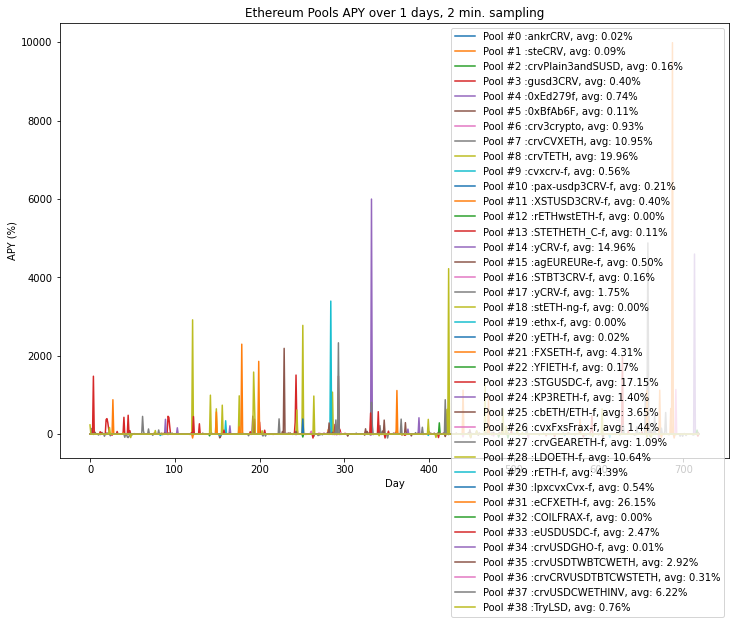

In [6]:
# Fetch virtual price, compute apys and plot results

duration_days = 1
frequency_minutes = 2

# Ethereum pools
apy_results_eth = {}
time_task_start = time.time()
plt.figure(figsize=(12,8))
for pool_index, pool_addr in enumerate(pool_store_eth):
    try:
        # Pool label
        sym = ""
        if "symbol" in pool_store_eth[pool_addr]:
            sym = pool_store_eth[pool_addr]["symbol"]
        else:
            sym = pool_addr[:8]

        print(f"Processing pool: {sym}")
        time_start = time.time()

        # Build the coroutines to fetch the virtual price
        coroutines = build_lambda_pricers(1, pool_addr, current_block_eth, duration_days, frequency_minutes)

        # Send requests
        results = requester.send_requests(coroutines)

        # Save cache updates
        with open('curve_requests/cache_vprice.json', 'w') as f:
            json.dump(cache_db, f)

        # Compute yearly APY from virtual price
        results = results[::-1] # Reverse order
        apy_list = []
        for i in range(len(results)-1):
            if results[i] and results[i+1]:
                # APY formula for reverse ordered virtual price
                # apy = (results[i] / results[i+1]) ** (365*24*60/frequency_minutes) - 1

                # APY formula for forward ordered virtual price
                apy = (results[i+1] / results[i]) ** (365*24*60/frequency_minutes) - 1
                apy *= 100
            else:
                # Can be None if eth_call failed. Set to 0
                apy = 0
            
            # Filter out outliers (investigate later)
            if apy > 10000:
                print(f"Outlier: {sym} {i} {apy}")
                apy = 0

            apy_list.append(apy)


        apy_results_eth[pool_addr] = apy_list
        avg_apy = sum(apy_list)/len(apy_list)
        # print(f"Pool avg. APY: {avg_apy:.2f} %")
        time_end = time.time()
        print(f"Pool {sym} processed in {time_end - time_start:.2f} s")
        
        # Display results, individual plot
        plt.plot(apy_list, label=f"Pool #{pool_index} :{sym}, avg: {avg_apy:.2f}%")

    except Exception as e:
        print(f"Error: {e}")
        break

time_task_end = time.time()
print(f"Total time: {time_task_end - time_task_start:.2f} s")

plt.legend()
plt.title(f"Ethereum Pools APY over {duration_days} days, {frequency_minutes} min. sampling")
plt.xlabel("Day")
plt.ylabel("APY (%)")
plt.show()


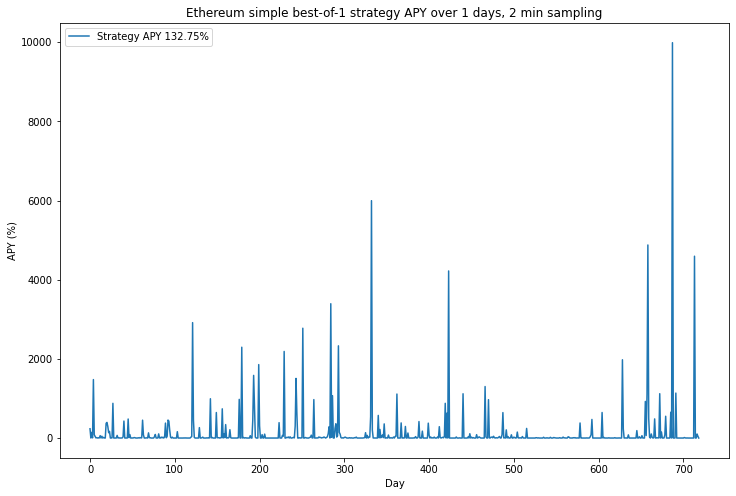

In [7]:
# Theoretical max. for strategy.
# Eggs in N baskets, select the top N pools, average their APYs.

n_baskets = 1

# Transform data from pool-apy list to apy-pool list
apy_list = []
n_samples = len(apy_results_eth[list(apy_results_eth.keys())[0]])
for i in range(n_samples):
    apy_list.append([])
    for pool_addr in apy_results_eth:
        apy_list[i].append(apy_results_eth[pool_addr][i])


# Compute the strategy APY at each time step
strat_apy_list = []

for i in range(n_samples):
    # Sort pools by APY
    apy_list[i].sort(reverse=True)
    # Select the top N pools
    apy_list[i] = apy_list[i][:n_baskets]
    # Average their APYs
    strat_apy_list.append(sum(apy_list[i])/n_baskets)


# Display result
plt.figure(figsize=(12,8))
plt.title(f"Ethereum simple best-of-{n_baskets} strategy APY over {duration_days} days, {frequency_minutes} min sampling")
plt.plot(strat_apy_list, label=f"Strategy APY {sum(strat_apy_list)/len(strat_apy_list):.2f}%")
plt.legend()
plt.xlabel("Day")
plt.ylabel("APY (%)")
plt.savefig(f"curve_backtest_simple_of_{n_baskets}_eth_{duration_days}days_{frequency_minutes}min.png", facecolor='w', edgecolor='w', transparent=False)
plt.show()

